### Nhập dữ liệu ###


In [ ]:
import pandas as pd
import gdown

# 1. Khai báo ID file
file_id = '1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS'
url = f'https://drive.google.com/uc?id={file_id}'

# 2. Tải file về bộ nhớ tạm của Colab
output = 'data.json'
gdown.download(url, output, quiet=False)

# 3. Đọc file bằng Pandas
# Lưu ý: Nếu file lớn, hãy kiểm tra xem có cần lines=True không
try:
    data = pd.read_json(output)
    print("Đọc thành công!")
    print(data.head())
except ValueError:
    # Thử lại với lines=True nếu file JSON dạng mỗi dòng 1 object
    data = pd.read_json(output, lines=True)
    print("Đọc thành công với lines=True!")
    print(data.head())

Downloading...
From: https://drive.google.com/uc?id=1D8a6VMN-NC9sG-84lUqbn0Qu8klrYvMS
To: /content/data.json
100%|██████████| 3.48M/3.48M [00:00<00:00, 63.7MB/s]


Đọc thành công!
          aspect    sentiment       date   source  \
0     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   
1  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
2     Chính sách     Tiêu cực 2025-08-01  FireAnt   
3  Diễn biến giá  Bình thường 2025-08-01  FireAnt   
4     Kinh doanh     Tiêu cực 2025-08-01  FireAnt   

                                       original_text date_str  
0  Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...      NaN  
1  Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...      NaN  
2  CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...      NaN  
3  Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...      NaN  
4  ❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...      NaN  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Thư viện Deep Learning (Keras/TensorFlow)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Thư viện Scikit-learn để hỗ trợ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# --- CẤU HÌNH THAM SỐ ĐÃ TỐI ƯU (HYPERPARAMETERS) ---
MAX_WORDS = 6000      # Giảm bớt từ vựng nhiễu (từ 8000 -> 6000)
MAX_LEN = 100         # Giữ nguyên
EMBEDDING_DIM = 64    # Giảm từ 128 -> 64 (Dữ liệu nhỏ dùng vector nhỏ sẽ đỡ overfit hơn)
EPOCHS = 20           # Tăng epoch lên vì ta sẽ dùng learning rate nhỏ hơn
BATCH_SIZE = 32
LEARNING_RATE = 1e-4  # 0.0001 (Học chậm lại để tìm điểm cực trị tốt hơn)
REG_RATE = 0.001      # Hệ số phạt L2


In [ ]:
import pandas as pd
import re

# ==============================================================================
# BƯỚC 1: HÀM LÀM SẠCH CỰC GỌN
# (Không cần train Word2Vec, không cần list từ chuẩn)
# ==============================================================================

def clean_text_simple(text):
    if not isinstance(text, str):
        return ""

    # 1. Chuyển chữ thường
    text = text.lower().strip()

    # 2. Loại bỏ URL
    text = re.sub(r'http\S+|www\S+', '', text)

    # 3. GIỮ LẠI: Chữ cái, Số, Tiếng Việt, Dấu gạch dưới (cho các từ dính nhau nếu có)
    # LOẠI BỎ: Emoji, dấu câu (.,!?), ký tự lạ
    # Regex này nghĩa là: Thay thế tất cả những gì KHÔNG PHẢI là chữ/số/tiếng Việt bằng khoảng trắng
    text = re.sub(r'[^\w\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]', ' ', text)

    # 4. Xử lý khoảng trắng thừa (biến nhiều dấu cách thành 1 dấu cách)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# ==============================================================================
# BƯỚC 2: ÁP DỤNG
# ==============================================================================

print("⏳ Đang làm sạch dữ liệu (Chế độ giữ nguyên Teencode)...")
data['cleaned_text'] = data['original_text'].apply(clean_text_simple)

print("✅ Kết quả:")
print(data[['original_text', 'cleaned_text']].head(10))

⏳ Đang làm sạch dữ liệu (Chế độ giữ nguyên Teencode)...
✅ Kết quả:
                                       original_text  \
0  Lên TT coi bà NPH nói về V mà sợ, bà đó hay th...   
1  Trụ gãy sạch ma20 nhưng midcap lại kéo trần? N...   
2  CHÍNH THỨC MỸ ÁP THUẾ 20% VỚI VIỆT NAM HẾT ĐỒN...   
3  Nay cuối tuần - phiên đầu tháng sau kỳ bctc Q2...   
4  ❤️❤️ suy nghĩ nào vhm bán đất hì hục 6 tháng l...   
5  ;;;;;;;; Chứng khoán Ngày thuế quan có hiệu lự...   
6  Ai yêu nước thì dập VIC chết mẹ nó đi, bắt tay...   
7                              1800 VHM 120. VIC 150   
8  🔥 31/7 – Giằng co vùng 1.500: Điều chỉnh hay t...   
9  Vn xuất qua mỹ bị đánh thuế 20% vậy xe điện vi...   

                                        cleaned_text  
0  lên tt coi bà nph nói về v mà sợ bà đó hay thi...  
1  trụ gãy sạch ma20 nhưng midcap lại kéo trần nđ...  
2  chính thức mỹ áp thuế 20 với việt nam hết đồn ...  
3  nay cuối tuần phiên đầu tháng sau kỳ bctc q2 s...  
4  suy nghĩ nào vhm bán đất hì hục 6 thán

In [ ]:
texts = data['cleaned_text'].astype(str).values
labels = data['sentiment'].values

    # Mã hóa nhãn (Label Encoding)
le = LabelEncoder()
labels_enc = le.fit_transform(labels)

    # One-Hot Encoding (cho model phân loại đa lớp)
labels_hot = to_categorical(labels_enc)
num_classes = labels_hot.shape[1]

print(f"✅ Đã xử lý xong {len(texts)} dòng dữ liệu.")
print(f"✅ Các nhãn lớp: {le.classes_}")

    # --- 4. TOKENIZATION & PADDING ---

    # Tạo bộ từ điển
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data_pad = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"✅ Kích thước dữ liệu đầu vào: {data_pad.shape}")

    # --- 5. CHIA TẬP TRAIN/TEST ---
X_train, X_test, y_train, y_test = train_test_split(
  data_pad, labels_hot,
  test_size=0.2,
  random_state=42,
  stratify=labels_enc
)

print("✅ Đã chia tập dữ liệu thành công!")
print(f"   - Train shape: {X_train.shape}")
print(f"   - Test shape:  {X_test.shape}")

✅ Đã xử lý xong 8199 dòng dữ liệu.
✅ Các nhãn lớp: ['Bình thường' 'Tiêu cực' 'Tích cực']
✅ Kích thước dữ liệu đầu vào: (8199, 100)
✅ Đã chia tập dữ liệu thành công!
   - Train shape: (6559, 100)
   - Test shape:  (1640, 100)


In [ ]:
def build_bilstm_model():
    model = Sequential()

    # Layer 1: Embedding
    # Thêm mask_zero=True để bỏ qua các giá trị 0 (padding)
    model.add(Embedding(input_dim=MAX_WORDS,
                        output_dim=EMBEDDING_DIM,
                        input_length=MAX_LEN,
                        mask_zero=False))

    # Layer 2: Bi-Directional LSTM
    # Giảm units xuống 32, thêm L2 regularization
    model.add(Bidirectional(LSTM(32,
                                 return_sequences=False,
                                 kernel_regularizer=l2(REG_RATE),
                                 recurrent_regularizer=l2(REG_RATE))))

    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(REG_RATE)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model
model = build_bilstm_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_bilstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("\n🚀 Bắt đầu huấn luyện mô hình...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)



🚀 Bắt đầu huấn luyện mô hình...
Epoch 1/20
202/205 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3364 - loss: 1.4287
Epoch 1: val_loss improved from inf to 1.31323, saving model to best_bilstm_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3364 - loss: 1.4277 - val_accuracy: 0.3652 - val_loss: 1.3132
Epoch 2/20
201/205 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3602 - loss: 1.3046
Epoch 2: val_loss improved from 1.31323 to 1.27307, saving model to best_bilstm_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3602 - loss: 1.3043 - val_accuracy: 0.3738 - val_loss: 1.2731
Epoch 3/20
203/205 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3930 - loss: 1.2539
Epoch 3: val_loss improved from 1.27307 to 1.22653, saving model to best_bilstm_model.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3932 - loss: 1.2537 - val_accuracy: 0.4195 - val_loss: 1.2265
Epoch 4/20
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4382 - loss:

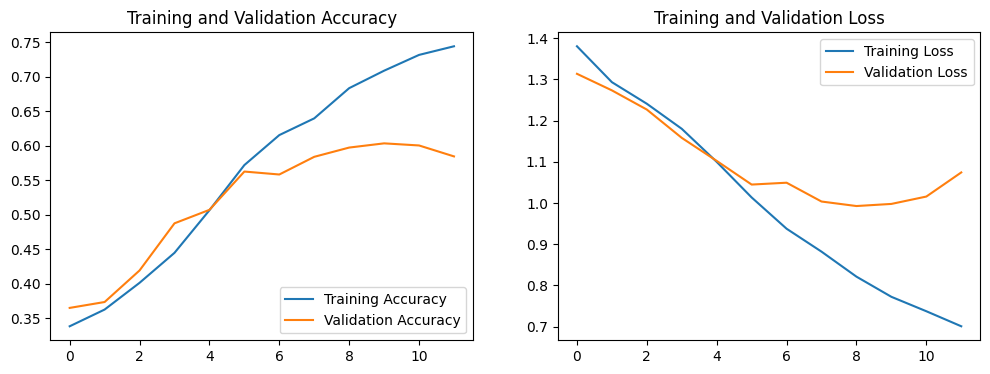


📊 ĐÁNH GIÁ TRÊN TẬP TEST:
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

 Bình thường       0.55      0.55      0.55       595
    Tiêu cực       0.58      0.69      0.63       524
    Tích cực       0.70      0.56      0.62       521

    accuracy                           0.60      1640
   macro avg       0.61      0.60      0.60      1640
weighted avg       0.61      0.60      0.60      1640



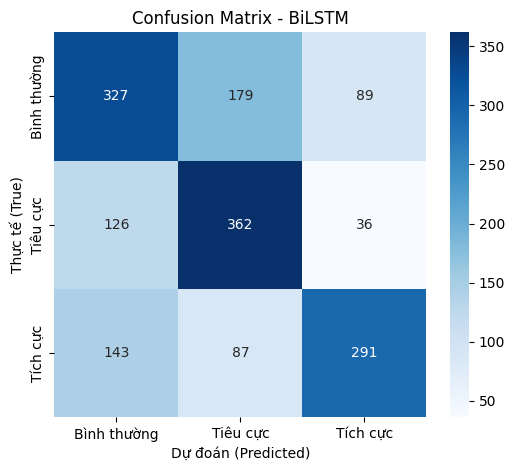

In [ ]:
# --- 4. VẼ BIỂU ĐỒ LOSS & ACCURACY ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

# --- 5. ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---
print("\n📊 ĐÁNH GIÁ TRÊN TẬP TEST:")

# Dự đoán xác suất
y_pred_probs = model.predict(X_test)
# Chuyển về nhãn số (lấy vị trí có xác suất cao nhất)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
# Chuyển y_test (one-hot) về nhãn số
y_true_classes = np.argmax(y_test, axis=1)

# Chuyển về tên nhãn (Positive, Negative...)
y_pred_labels = le.inverse_transform(y_pred_classes)
y_true_labels = le.inverse_transform(y_true_classes)

# In báo cáo
print(classification_report(y_true_labels, y_pred_labels))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (True)')
plt.title('Confusion Matrix - BiLSTM')
plt.show()

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Đã lưu Tokenizer tại: tokenizer.pickle")

# 3. Lưu Label Encoder (Để biến số 0,1,2 thành nhãn Positive/Negative)
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Đã lưu Label Encoder tại: label_encoder.pickle")

✅ Đã lưu Tokenizer tại: tokenizer.pickle
✅ Đã lưu Label Encoder tại: label_encoder.pickle


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# --- CẤU HÌNH (Phải khớp với lúc train) ---
MAX_LEN = 100

# 1. LOAD CÁC FILE ĐÃ LƯU
print("⏳ Đang tải tài nguyên...")

# Load Model
loaded_model = load_model('best_bilstm_model.keras')

# Load Tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Load Label Encoder
with open('label_encoder.pickle', 'rb') as handle:
    loaded_le = pickle.load(handle)

print("✅ Đã tải xong toàn bộ hệ thống!")

# 2. ĐỊNH NGHĨA LẠI HÀM LÀM SẠCH (Cần có để xử lý input mới)
# (Copy lại hàm clean_text_optimized của bạn vào đây nếu sang file mới)
# Nếu đang chạy cùng notebook thì không cần define lại, nhưng để chắc chắn tôi để ở đây:

teencode_dict = {
    "k": "không", "ko": "không", "kh": "không", "hok": "không",
    "dc": "được", "dk": "được",
    "ck": "chứng khoán", "cp": "cổ phiếu",
    "mn": "mọi người", "ae": "anh em",
    "ad": "admin", "tks": "cảm ơn", "vni": "vnindex",
}

def clean_text_for_pred(text):
    if not isinstance(text, str): return ""
    text = text.lower().strip()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s,.!?]', ' ', text)
    words = text.split()
    words = [teencode_dict.get(word, word) for word in words]
    text = " ".join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 3. HÀM DỰ ĐOÁN
def predict_sentiment(sentences):
    # Bước 1: Làm sạch
    cleaned_sentences = [clean_text_for_pred(s) for s in sentences]

    # Bước 2: Tokenize & Padding (Dùng loaded_tokenizer)
    sequences = loaded_tokenizer.texts_to_sequences(cleaned_sentences)
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

    # Bước 3: Dự đoán
    predictions = loaded_model.predict(padded, verbose=0)

    # Bước 4: Giải mã kết quả
    results = []
    for i, text in enumerate(sentences):
        pred_prob = predictions[i]
        pred_idx = np.argmax(pred_prob)
        label = loaded_le.inverse_transform([pred_idx])[0]
        confidence = pred_prob[pred_idx] * 100

        results.append({
            "Câu gốc": text,
            "Dự đoán": label,
            "Độ tin cậy": f"{confidence:.2f}%"
        })
    return results

# --- 4. CHẠY THỬ NGHIỆM ---
new_samples = [
    "Thị trường sập mạnh quá, bán hết nghỉ chơi thôi.",
    "Tuyệt vời, hôm nay chốt lời được 20%, cảm ơn admin.",
    "Con này lình xình mãi không chạy, chán ghê.",
    "Mã này cơ bản tốt, cứ nắm giữ dài hạn là có ăn.",
    "Hôm nay trời đẹp nhưng cổ phiếu thì đỏ lửa."
]

print("\n🔍 KẾT QUẢ DỰ ĐOÁN:")
final_results = predict_sentiment(new_samples)

# In đẹp
for res in final_results:
    print("-" * 50)
    print(f"💬: {res['Câu gốc']}")
    print(f"🤖: {res['Dự đoán']} (Tin cậy: {res['Độ tin cậy']})")

⏳ Đang tải tài nguyên...
✅ Đã tải xong toàn bộ hệ thống!

🔍 KẾT QUẢ DỰ ĐOÁN:
--------------------------------------------------
💬: Thị trường sập mạnh quá, bán hết nghỉ chơi thôi.
🤖: Tiêu cực (Tin cậy: 88.55%)
--------------------------------------------------
💬: Tuyệt vời, hôm nay chốt lời được 20%, cảm ơn admin.
🤖: Tích cực (Tin cậy: 84.80%)
--------------------------------------------------
💬: Con này lình xình mãi không chạy, chán ghê.
🤖: Tiêu cực (Tin cậy: 89.60%)
--------------------------------------------------
💬: Mã này cơ bản tốt, cứ nắm giữ dài hạn là có ăn.
🤖: Tích cực (Tin cậy: 64.50%)
--------------------------------------------------
💬: Hôm nay trời đẹp nhưng cổ phiếu thì đỏ lửa.
🤖: Tiêu cực (Tin cậy: 54.05%)
